# Network Analysis - “Who are the key players for Netflix?”

## Introduction: 
In 2007, a decade after going into the film and television distribution business as a DVD rental by mail company, Netflix made a bold move that would change the way people watch television for the times to come. They launched the first commercially successful subscription video-on-demand service, forever changing the entertainment distribution and consumption paradigm. For the first time, the audience could now watch what they wanted, when they wanted, so long as the content they were looking for was available on the service. Today Netflix has over 214 million subscribers worldwide, including 74 million in the United States. As a data-driven company, they are known to perform extensive analysis on the viewership data they collect from their users. These analyses inform much of the decision-making processes within the company, including what content to license, commission, or produce. Questions such as what content to greenlight, who is a better actor for a given role, and who would be a good director for a given film are all answered with data within the organization. However, as of today, this information is mainly kept close to their chest. Identifying the key players in the film industry, especially those contributing to Netflix's success, can provide valuable insights into the elements driving the platform's popularity and growth. By understanding the roles and impact of these individuals, Netflix can better strategize content acquisition, creation, and marketing to maintain its competitive edge and satisfy its diverse subscriber base.

## Goals and methodology:
In the following analysis, I aim to answer the overarching question of who the key individuals for Netflix’s success are by performing network analyses. This project will focus on the titles currently available for viewing in the United States; however, these same concepts could be extended to other countries. Unfortunately, Netflix doesn’t make their viewership information available, but beginning around the second quarter of 2020, they started posting their daily top 10 ranking in film and television. We will use this data as a proxy measure of success by awarding each title 10 points for each day it ranks number one, 9 points for each day it ranks number two, and so on. The final score is the sum of points during the entire period for which a given title ranked in the top 10. Any title released since they began posting rankings publicly but that did not rank in the top 10 is awarded the default value of 1 point. This data is then enriched by cross-referencing the titles with existing movie databases, such as IMDb, to obtain the key talent involved. With this data at hand, we build a weighted undirected graph where the nodes represent the talent, the edges represent the movies they worked together in, and the edge weights are the total ranking score for a given title. Network analysis was chosen to answer the research question due to its ability to uncover complex relationships and interactions among individuals involved in the film industry. By examining the connections between key personnel in various projects, we can gain insights into the structure and dynamics of the industry and identify the most influential players based on their positions within the network. However, our analysis is subject to certain limitations and assumptions. First, the data used is derived from publicly available sources, which may not be entirely accurate or comprehensive. Second, the ranking system used as a proxy for viewership may not fully represent the popularity or success of a given title. Additionally, our analysis focuses on the US market, which may not be generalizable to other regions. Finally, the network analysis method itself has inherent limitations, as it assumes that connections between individuals are equal in importance and may not account for other factors influencing the success of a project, such as marketing efforts or production budgets.

# Libraries

In [56]:
import pandas as pd
import statistics as stats
import networkx as nx
from utils import get_country_dfs, get_colab_matrix, graph
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Turn off the warnings
warnings.filterwarnings('ignore')

# Set the plt style to "ggplot"
plt.style.use('ggplot')

# Set the style to "darkgrid"
sns.set_style('darkgrid')

# Data

In [57]:
df = pd.read_pickle('data/netflixmoviemain_df.pkl')
titles = pd.read_pickle('data/titles.pkl')
talent = pd.read_pickle('data/talent.pkl')
talent = talent.merge(titles[['jw_entity_id', 'original_release_year', 'genre_1']], on='jw_entity_id', how='left')

# Create a feature called 'tenure' to measure the number of years between the earliest movie and the latest movie of each talent
talent['tenure'] = talent.groupby('person_id')['original_release_year'].transform(lambda x: x.max() - x.min())


local_df, local_talent = get_country_dfs('Mexico', df, talent)

colab_matrix = get_colab_matrix(local_df, local_talent)
G, centrality_measures = graph(colab_matrix)

# Results and remarks: 

In [21]:
print("The resulting graph contains {:,} nodes,".format(G.number_of_nodes()))
print("representing the key talent involved in making the content available on Netflix during the period under study.")

The resulting graph contains 27,235 nodes,
representing the key talent involved in making the content available on Netflix during the period under study.


Most of these individuals are actors, as shown in the figure below:

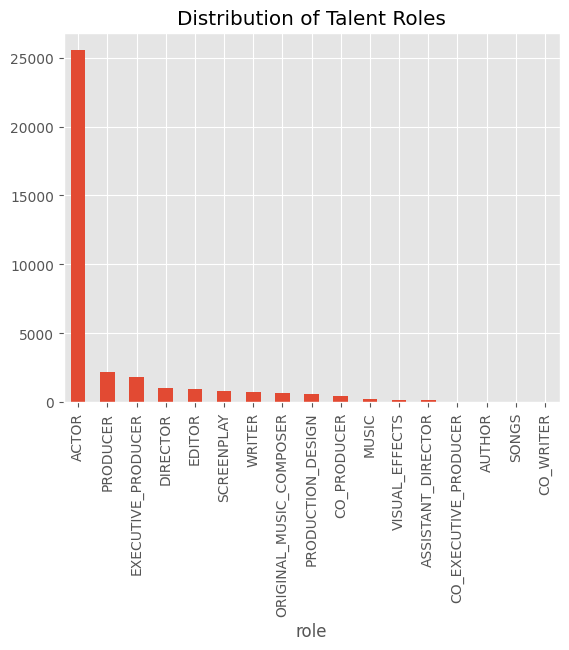

In [22]:
local_talent['role'].value_counts().plot(kind='bar')
plt.title('Distribution of Talent Roles')
plt.show()

In [23]:
print("These key personnel collaborated in {:,} titles".format(len(local_talent['title'].unique())))
print("forming {:,} edges between them during this period.".format(G.number_of_edges()))

These key personnel collaborated in 973 titles
forming 857,292 edges between them during this period.


In [58]:
S = [G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len, reverse=True)]

sub_graph_summary = pd.DataFrame()

for i, sub_G in enumerate(S):
    measures = {}
    measures['num_nodes'] = sub_G.number_of_nodes()
    measures['num_edges'] = sub_G.number_of_edges()
    measures = pd.DataFrame(measures, index=[i])
    sub_graph_summary = pd.concat([sub_graph_summary, measures], ignore_index=True)

In [38]:
print("However, the resulting graph is not fully connected. It contains {:,} separate sub-graphs.".format(len(S)))
print("The largest connected component contains {:,} nodes and {:,} edges.".format(sub_graph_summary['num_nodes'].max(), sub_graph_summary['num_edges'].max()))
print("{:.2%} of nodes reside in this one large, connected subgraph.".format(sub_graph_summary['num_nodes'].max() / G.number_of_nodes()))

However, the resulting graph is not fully connected. It contains 85 separate sub-graphs.
The largest connected component contains 26,240 nodes and 849,115 edges.
96.35% of nodes reside in this one large, connected subgraph.


In [40]:
# Network metric statistics
def network_metric_statistics(metric_data):
    avg = stats.mean(metric_data)
    med = stats.median(metric_data)
    std = stats.stdev(metric_data)
    
    return("The average degree of the nodes is " + '{:.2f}'.format(avg) + ", with a median of " + '{:.2f}'.format(med) + ", and a standard deviation of " + '{:.2f}'.format(std))

degree_sequence = sorted((S[0].degree[d] for d in list(S[0].nodes)), reverse=True)  # for nx v2
network_metric_statistics(degree_sequence)

'The average degree of the nodes is 64.72, with a median of 53.00, and a standard deviation of 50.59'

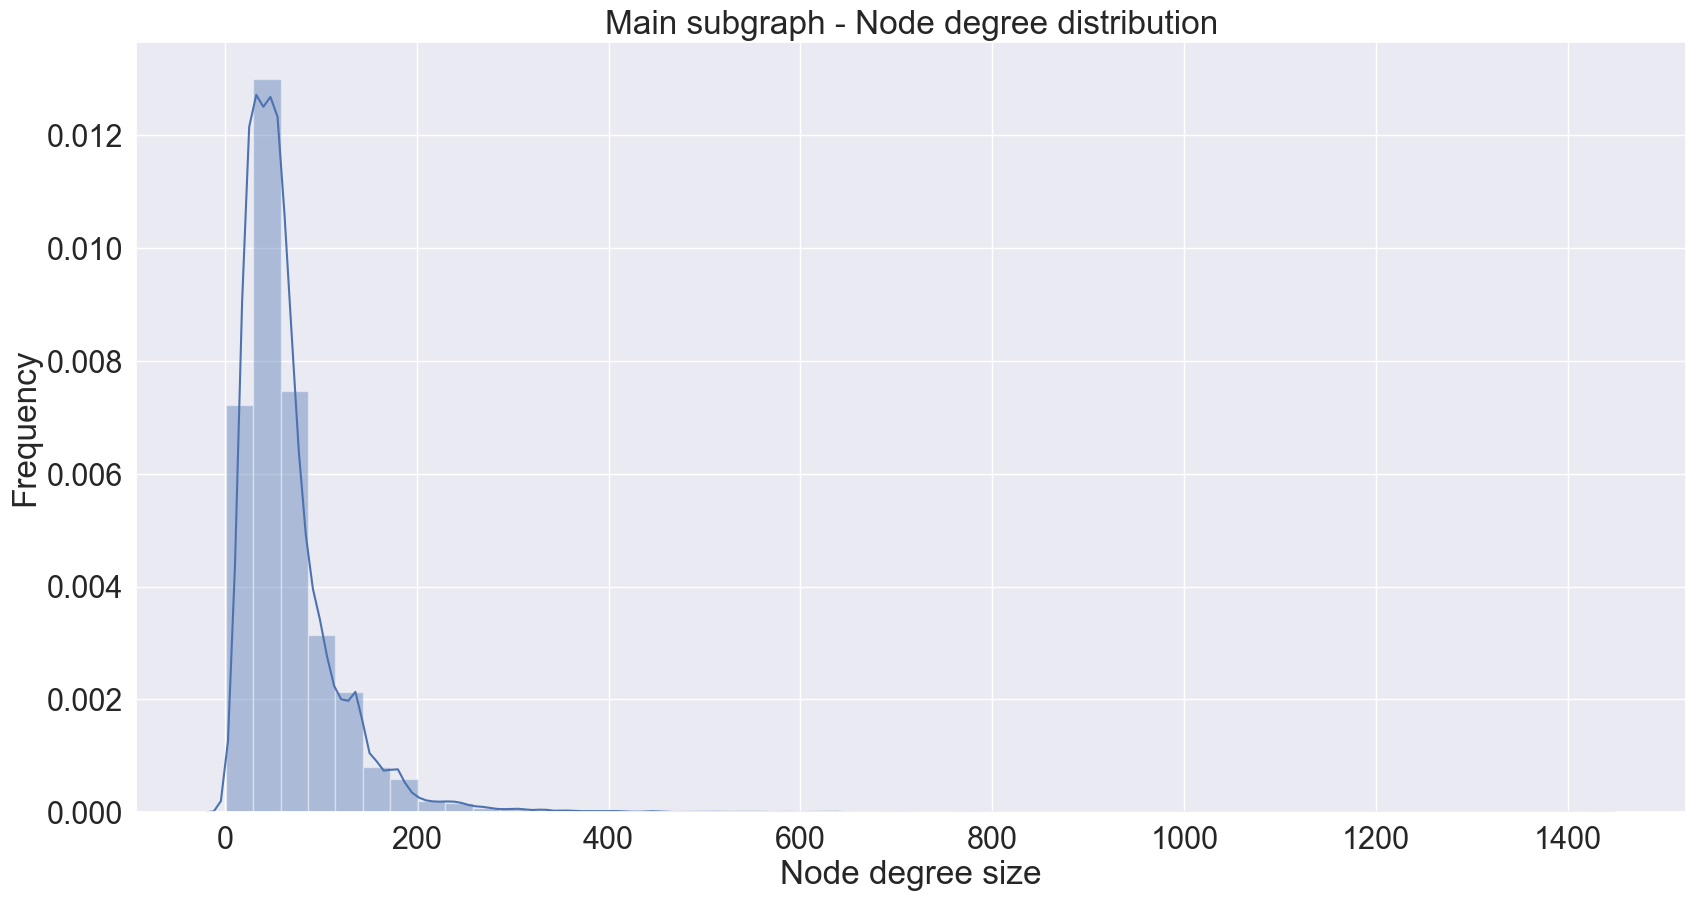

In [59]:
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(20,10))
sns.set(font_scale=2)
ax = sns.distplot(degree_sequence)
ax.set(xlabel="Node degree size",ylabel= "Frequency",title='Main subgraph - Node degree distribution');
plt.show()

The node degree distribution seems fairly Gaussian, with a long tail in the upper range.

In [44]:
# Other characteristics of the graph
def graph_characteristics(graph):
    measures = {}
    measures['diameter'] = nx.diameter(graph)
    measures['density'] = nx.density(graph)
    measures['triangles'] = len(nx.triangles(graph))
    measures['transitivity'] = nx.transitivity(graph)
    measures['avg_clustering'] = nx.average_clustering(graph)
    measures = pd.DataFrame(measures, index=[0])
    return(measures)

main_sub_graph_characteristics = graph_characteristics(S[0])

In [52]:
print("Interestingly, the diameter of this central subgraph is {diameter:}, \nmeaning that there are at most {diameter:} degrees of separation between any one member of this network.".format(diameter = str(main_sub_graph_characteristics['diameter'].values[0])))
print("The density of the graph is relatively small at {density:.2%}.".format(density = main_sub_graph_characteristics['density'].values[0]))
print("However, there are many triangles in the graph, {triangles:,} to be exact.".format(triangles = main_sub_graph_characteristics['triangles'].values[0]))
print("This means that {transitivity:.2%} of the connected triples of nodes in the graph are triangles.".format(transitivity = main_sub_graph_characteristics['transitivity'].values[0]))
print("The average clustering coefficient of the graph is {avg_clustering:.2%}. indicating a large concentration of fully connected triples.".format(avg_clustering = main_sub_graph_characteristics['avg_clustering'].values[0]))

Interestingly, the diameter of this central subgraph is 13, 
meaning that there are at most 13 degrees of separation between any one member of this network.
The density of the graph is relatively small at 0.25%.
However, there are many triangles in the graph, 26,240 to be exact.
This means that 66.75% of the connected triples of nodes in the graph are triangles.
The average clustering coefficient of the graph is 92.01%. indicating a large concentration of fully connected triples.


To identify who amongst these individuals we consider important, we will look at three key metrics: degree centrality, eigenvector centrality, and page-rank centrality. The top 10 individuals for each of these metrics are shown below:
### Top 10 key players by degree centrality:

In [53]:
names = local_talent.groupby(['person_id', 'name'])[['person_id', 'name','role']].head(1)
names.index = names['person_id']
names.drop('person_id', axis=1, inplace=True)
deg_cent = pd.DataFrame.from_dict(nx.degree_centrality(S[0]), orient='index', columns=['degree_centrality'])
eig = pd.DataFrame.from_dict(nx.eigenvector_centrality(S[0]), orient='index', columns=['eigenvector_centrality'])
page_rank = pd.DataFrame.from_dict(nx.pagerank(S[0], alpha = 0.85), orient='index', columns=['page_rank_centrality'])
centralities = pd.concat([names, deg_cent, eig, page_rank], axis=1).dropna()
centralities[['name', 'role', 'degree_centrality']].sort_values('degree_centrality', ascending=False).head(10)

,name,role,degree_centrality
2779,Steven Spielberg,PRODUCER,0.054499
1728,Hans Zimmer,ORIGINAL_MUSIC_COMPOSER,0.029727
1683,John Debney,ORIGINAL_MUSIC_COMPOSER,0.029384
2117,John Williams,ORIGINAL_MUSIC_COMPOSER,0.026830
3341,Michael Papajohn,ACTOR,0.026754
1802,J.K. Simmons,ACTOR,0.024353
3535,Tom Cruise,ACTOR,0.024315
4273,Tim Bevan,PRODUCER,0.023972
4280,Eric Fellner,PRODUCER,0.023972
3748,Robert De Niro,ACTOR,0.023438


### Top 10 key players by eigenvector centrality:

In [54]:
centralities[['name', 'role', 'eigenvector_centrality']].sort_values('eigenvector_centrality', ascending=False).head(10)

,name,role,eigenvector_centrality
1865,Stan Lee,ACTOR,0.085029
5383,Avi Arad,PRODUCER,0.084559
1876,Kevin Feige,PRODUCER,0.083133
1802,J.K. Simmons,ACTOR,0.080868
77800,Matt Tolmach,EXECUTIVE_PRODUCER,0.077752
9934,Pat Kiernan,ACTOR,0.075797
9730,David Minkowski,CO_PRODUCER,0.075492
9729,Matthew Stillman,CO_PRODUCER,0.075492
10960,Martin Starr,ACTOR,0.075254
87626,Chris McKenna,WRITER,0.074783


### Top 10 key players by PageRank centrality

In [55]:
centralities[['name', 'role', 'page_rank_centrality']].sort_values('page_rank_centrality', ascending=False).head(10)

,name,role,page_rank_centrality
2779,Steven Spielberg,PRODUCER,0.000502
1728,Hans Zimmer,ORIGINAL_MUSIC_COMPOSER,0.000343
1683,John Debney,ORIGINAL_MUSIC_COMPOSER,0.000320
17760,Ronnie Screwvala,PRODUCER,0.000320
3748,Robert De Niro,ACTOR,0.000296
2708,Neal H. Moritz,PRODUCER,0.000286
4280,Eric Fellner,PRODUCER,0.000283
4273,Tim Bevan,PRODUCER,0.000283
3341,Michael Papajohn,ACTOR,0.000263
929,Marco Beltrami,ORIGINAL_MUSIC_COMPOSER,0.000259


Identifying key players based on various centrality measures has significant implications for both Netflix and the broader film industry. For Netflix, understanding the roles and influence of these individuals can help the company make more informed decisions regarding content creation and acquisition. For instance, by collaborating with producers, directors, and actors with high centrality scores, Netflix can potentially increase the likelihood of producing successful content that resonates with its target audience. Furthermore, the company can use this information to identify emerging talent and invest in projects that feature such individuals, allowing them to diversify their content offerings and foster innovation within the platform. For the film industry as a whole, recognizing the key players can help reveal patterns of collaboration and success, allowing other industry stakeholders to adapt their strategies and better compete in the ever-changing landscape of content production and distribution.

# Final thoughts: 
One of the most surprising results from these analyses is that, although most of the people involved in the network are actors, most of the players central to Netflix are not. Degree centrality, which is based on the fact that important people have many connections, predictably shows that producers primarily dominate the top rank. This understanding coincides with a producer's role in producing film and television content, where they are tasked with making the connections necessary for a project to be realized. On the other hand, eigenvector centrality, which aims to rate players by the importance of their neighbors, shows a higher percentage of actors. Finally, PageRank centrality, which rates players by the centrality of their connections, offers the most diverse group of individuals.
This network offers many opportunities for further analyses, such as finding cliques and communities and characterizing the content that such communities produce. Unfortunately, using viewership ranking as a proxy measure of actual viewership is not ideal, so results should be taken with some precautions. Future research could build on the findings of this study by further exploring other aspects of the network, such as the role of specific genres, production budgets, or audience demographics in shaping the relationships between key players. Additionally, a more in-depth analysis could be conducted to understand how these key individuals contribute to Netflix's success, including examining their involvement in critically acclaimed or commercially successful projects. Finally, expanding the scope of the analysis to include other streaming platforms or international markets could also provide valuable insights into the dynamics of the global film industry and the factors driving success across different platforms and regions.